In [1]:
import pandas as pd
import sys
import yaml 
import glob 
import os

from tqdm import tqdm

sys.path.append("../../../utils")
from absolute_path_builder import AbsolutePathBuilder

In [2]:
aae_terms_path = AbsolutePathBuilder.get_path(
    "00_aae_terms",
    filepaths="../../../config/filepaths.yaml"
)

terms = yaml.safe_load(open(aae_terms_path))["terms"]

In [3]:
DATASET = "buckeye"

data_path = AbsolutePathBuilder.get_path(
    f"05_{DATASET}_features",
    filepaths="../../../config/filepaths.yaml"
)

### Load data into a single dataframe

In [4]:
dfs = []

filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(data_path, "*"))]
for i, file in enumerate(tqdm(filenames)):
    df = pd.read_csv(os.path.join(data_path, file))
    # Unique index to group information of a single file
    df["FILE_ID"] = i

    dfs.append(df)

100%|████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 141.31it/s]


In [5]:
df = pd.concat(dfs)

### Calculate the number of AAE terms and files in each race

In [6]:
df["n_words"] = df.text.apply(lambda s: len(s.split()))

In [7]:
df_grouped = (
    df.groupby("race")
    .agg(
        n_sentences=("text", "count"),
        n_words=("n_words", "sum"),
        n_aae_terms=("AAE_TERMS_COUNT", "sum"),
        n_files=("FILE_ID", "nunique")
    )
)

df_grouped["avg_terms_per_file"] = df_grouped.n_aae_terms / df_grouped.n_files
df_grouped["avg_terms_per_sentence"] = df_grouped.n_aae_terms / df_grouped.n_sentences

In [8]:
df_grouped

,n_sentences,n_words,n_aae_terms,n_files,avg_terms_per_file,avg_terms_per_sentence
race,,,,,,
White,19304,275830,18712,39,479.794872,0.969333


### Calculate the number of AAE terms in each file

In [9]:
df_grouped = (
    df.groupby("FILE_ID")
    .agg(
        n_aae_terms=("AAE_TERMS_COUNT", "sum"),
        race=("race", "first")
    )
)

/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/guilherme/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/guilherme/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/guilherme/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will

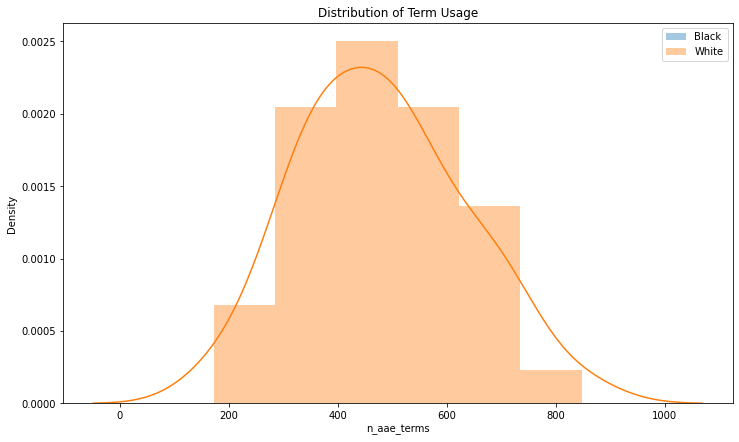

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(12,7))

sns.distplot(df_grouped.loc[df_grouped.race == "Black", "n_aae_terms"], label="Black")
sns.distplot(df_grouped.loc[df_grouped.race == "White", "n_aae_terms"], label="White")

plt.legend()
plt.title("Distribution of Term Usage")
plt.show()